In [ ]:
!pip install -q -U \
    transformers[torch]==4.40.2 \
    datasets==2.19.1 \
    evaluate==0.4.2 \
    rouge_score==0.1.2 \
    sentencepiece==0.2.0 \
    accelerate==0.30.1

In [ ]:
import datasets
import evaluate
import nltk
import numpy as np
import transformers

In [ ]:
!git lfs install
!git clone https://huggingface.co/booksouls/flan-t5-base

Git LFS initialized.
fatal: destination path 'flan-t5-base' already exists and is not an empty directory.


In [ ]:
MODEL_NAME = "flan-t5-base"
MAX_SOURCE_LENGTH = 1024
MAX_TARGET_LENGTH = 256

In [ ]:
dataset = datasets.load_dataset("booksouls/booksum-cleaned")

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

In [ ]:
def tokenize(books):
    inputs = [
        "summarize: " + chapter
        for chapter in books["chapter"]
    ]
    result = tokenizer(
        inputs,
        max_length=MAX_SOURCE_LENGTH,
        padding="max_length",
        truncation=True,
    )
    labels = tokenizer(
        text_target=books["summary"],
        max_length=MAX_TARGET_LENGTH,
        padding="max_length",
        truncation=True,
    )
    result["labels"] = labels["input_ids"]
    return result

tokenized_dataset = dataset.map(
    tokenize,
    batched=True,
    remove_columns=["chapter", "summary"]
)

In [ ]:
rouge = evaluate.load("rouge")

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def postprocess_output(output):
    return [
        # rouge-Lsum expects newline after each sentence.
        "\n".join(nltk.sent_tokenize(text.strip()))
        for text in output
    ]

def compute_metrics(eval_prediction):
    predictions, labels = eval_prediction
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Replace -100s used for padding as we can't decode them.
    predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    predictions_decoded = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels_decoded = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(
        predictions=postprocess_output(predictions_decoded),
        references=postprocess_output(labels_decoded),
        use_stemmer=True,
    )

    result["gen_len"] = np.mean([
        np.count_nonzero(prediction != tokenizer.pad_token_id)
        for prediction in predictions
    ])

    return {
        key: round(value, 6)
        for key, value in result.items()
    }

In [ ]:
training_args = transformers.Seq2SeqTrainingArguments(
    output_dir=MODEL_NAME,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=64,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    predict_with_generate=True,
    push_to_hub=True,
    hub_strategy="checkpoint",
)

optimizer = transformers.Adafactor(
    model.parameters(),
    lr=1e-4,
    scale_parameter=False,
    relative_step=False,
)

trainer = transformers.Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,3.439300,2.525513,0.197282,0.027237,0.142986,0.175376,253.857824


In [ ]:
trainer.train(resume_from_checkpoint=f"{MODEL_NAME}/last-checkpoint")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.736400,2.475057,0.246374,0.037955,0.156475,0.222166,253.250199


In [ ]:
trainer.train(resume_from_checkpoint=f"{MODEL_NAME}/last-checkpoint")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
2,2.667400,2.440944,0.228745,0.034109,0.154501,0.204481,253.877681


KeyboardInterrupt: 

In [ ]:
trainer.train(resume_from_checkpoint=f"{MODEL_NAME}/last-checkpoint")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
3,2.629400,2.429676,0.256769,0.040838,0.159572,0.231634,252.109611


In [ ]:
trainer.train(resume_from_checkpoint=f"{MODEL_NAME}/last-checkpoint")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
4,2.602100,2.418489,0.248776,0.039076,0.159504,0.224587,254.393963


In [ ]:
trainer.train(resume_from_checkpoint=f"{MODEL_NAME}/last-checkpoint")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
5,2.581200,2.409210,0.248708,0.040046,0.161300,0.223846,253.453535


In [ ]:
trainer.train(resume_from_checkpoint=f"{MODEL_NAME}/last-checkpoint")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
6,2.565400,2.405317,0.255076,0.040960,0.161739,0.229909,253.435266


In [ ]:
trainer.train(resume_from_checkpoint=f"{MODEL_NAME}/last-checkpoint")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
7,2.553400,2.401743,0.250202,0.040552,0.160570,0.225614,253.668785


In [ ]:
trainer.train(resume_from_checkpoint=f"{MODEL_NAME}/last-checkpoint")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
8,2.546100,2.399357,0.254394,0.040700,0.161370,0.230163,253.401112


In [ ]:
trainer.train(resume_from_checkpoint=f"{MODEL_NAME}/last-checkpoint")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
9,2.516200,2.398547,0.255173,0.041657,0.161811,0.230633,253.612391


TrainOutput(global_step=630, training_loss=0.2516208709232391, metrics={'train_runtime': 6996.3932, 'train_samples_per_second': 11.642, 'train_steps_per_second': 0.09, 'total_flos': 1.1660459051896013e+17, 'train_loss': 0.2516208709232391, 'epoch': 9.989933709796219})

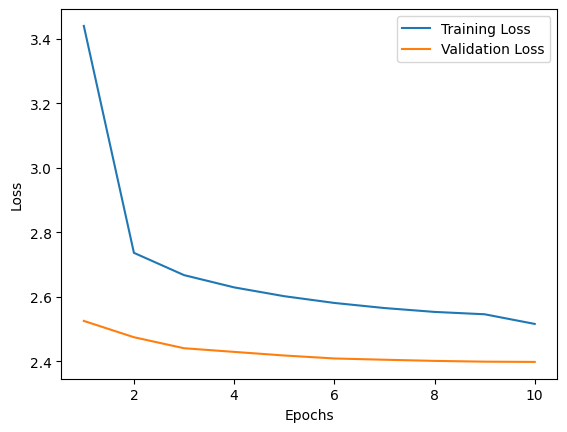

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.array([1,2,3,4,5,6,7,8,9,10])
train_loss = np.array([3.4393,2.7364,2.6674,2.6294,2.6021,2.5812,2.5654,2.5534,2.5461,2.5162])
val_loss = np.array([2.5255,2.4750,2.4409,2.4296,2.4184,2.4092,2.4053,2.4017,2.3993,2.3985])

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [ ]:
epochs = np.array([1,2,3,4,5,6,7,8,9,10])
rouge1 = np.array([0.1972,2.4637,0.2287,0.2567,0.2487,0.2487,0.2550,0.2502,0.2543,0.2551])
rouge2 = np.array([2.5255,2.4750,2.4409,2.4296,2.4184,2.4092,2.4053,2.4017,2.3993,2.3985])
rougel = np.array([3.4393,2.7364,2.6674,2.6294,2.6021,2.5812,2.5654,2.5534,2.5461,2.5162])
rougelsum = np.array([2.5255,2.4750,2.4409,2.4296,2.4184,2.4092,2.4053,2.4017,2.3993,2.3985])

plt.plot(epochs, rouge1, label="Rouge1")
plt.plot(epochs, rouge2, label="Rouge2")
plt.plot(epochs, rougel, label="RougeL")
plt.plot(epochs, rougelsum, label="RougeLsum")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Rouge Scores")

plt.show()